In [49]:
from jax import config; config.update("jax_enable_x64", True)
from jax import numpy as jnp
from jax import jit, vmap
import numpy as np

import polars as pl
from polars import col, lit

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score
from mapie.metrics import regression_mean_width_score

from plotnine import ggplot
import plotnine as p9

In [50]:
LINK = "http://www.bamlss.org/misc/rent99.raw"
df = pl.read_csv(LINK, separator=" ")
df = df.with_columns(col("yearc").cast(pl.Int32).cast(pl.Utf8).str.to_date(format="%Y")).rename({"yearc": "year"})
df.head()

rent,rentsqm,area,year,location,bath,kitchen,cheating,district
f64,f64,i64,date,i64,i64,i64,i64,i64
120.974358,3.45641,35,1939-01-01,1,0,0,0,1112
436.974335,4.201676,104,1939-01-01,1,1,0,1,1112
355.743591,12.267021,29,1971-01-01,2,0,0,1,2114
282.923096,7.254436,39,1972-01-01,2,0,0,1,2148
807.230774,8.321964,97,1985-01-01,1,0,0,1,2222


In [51]:
y = df["rent"]
X = df.drop("rent")

X_train, X_rest1, y_train, y_rest1 = train_test_split(X, y, test_size=2000, random_state=2)
X_test, X_rest2, y_test, y_rest2 = train_test_split(X_rest1, y_rest1, test_size=1500, random_state=4)
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2, y_rest2, test_size=500, random_state=42)



In [4]:
params = {
    'n_estimators': [10, 50, 100, 500, 1000],
    'max_depth': [None, 1, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
# The model is a random forest
model = RandomForestRegressor()
# Create the random search object using 5-fold cross-validation
random_search = RandomizedSearchCV(
  estimator=model, param_distributions=params, cv=5,
  n_iter=10, random_state=0
)
# Fit the random search to the data
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [None, 1, 2, 5, 10],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 500,
                                                         1000]},
                   random_state=0)

In [5]:
model = RandomForestRegressor(
  **random_search.best_params_, random_state=1
)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=500, random_state=1)

In [6]:
mapie_reg = MapieRegressor(estimator=model, cv='prefit')
mapie_reg.fit(X_calib, y_calib)
y_pred, y_pis = mapie_reg.predict(X_new, alpha=.95)

print(X_new[0])
print("Predicted rent: {:.2f}".format(y_pred[0]))
interval = y_pis[0].flatten()
print("95% interval: [{:.2f};{:.2f}]".format(interval[0], interval[1]))
print("True rent: {:.2f}".format(y_new[0]))

shape: (1, 8)
┌─────────┬──────┬────────────┬──────────┬──────┬─────────┬──────────┬──────────┐
│ rentsqm ┆ area ┆ year       ┆ location ┆ bath ┆ kitchen ┆ cheating ┆ district │
│ ---     ┆ ---  ┆ ---        ┆ ---      ┆ ---  ┆ ---     ┆ ---      ┆ ---      │
│ f64     ┆ i64  ┆ date       ┆ i64      ┆ i64  ┆ i64     ┆ i64      ┆ i64      │
╞═════════╪══════╪════════════╪══════════╪══════╪═════════╪══════════╪══════════╡
│ 5.8036  ┆ 47   ┆ 1932-01-01 ┆ 1        ┆ 0    ┆ 0       ┆ 1        ┆ 1812     │
└─────────┴──────┴────────────┴──────────┴──────┴─────────┴──────────┴──────────┘
Predicted rent: 267.49
95% interval: [267.06;267.92]
True rent: 272.77


In [7]:
size = regression_mean_width_score(y_pis[:,0], y_pis[:,1])
cov = regression_coverage_score(y_new, y_pis[:,0], y_pis[:,1])

print("Avg. interval size: {:.2f}".format(size))
print("Coverage: {:.2%}".format(cov))

Avg. interval size: 0.86
Coverage: 6.00%


/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/mapie/utils.py:621: UserWarning: WARNING: The predictions are ill-sorted.


In [8]:
class VariancePredictor:
    def __init__(self, model=None, n_estimators=100):
        if model is not None:
            self.model = model
        else:
            self.model = RandomForestRegressor(n_estimators=n_estimators)
        
    def fit(self, X, y):
        # pass if fit already called
        if hasattr(self.model, "estimators_"):
            pass
        else:
            self.model.fit(X, y)
    
    def predict(self, X):
        # Get individual tree predictions
        all_predictions = np.array([tree.predict(X) for tree in self.model.estimators_])
        
        # Compute the variance of the predictions
        variance_predictions = np.var(all_predictions, axis=0)
        
        return variance_predictions


class AdaptiveConformalRegression:
    def __init__(self, prediction_fn, var_prediction_fn, alpha=0.1):
        self.prediction_fn = prediction_fn
        self.var_prediction_fn = var_prediction_fn
        self.alpha = alpha
        self.qhat = None

    def score_fn(self, y, y_hat, sigma_hat):
        return jnp.abs(y - y_hat) / sigma_hat

    def fit(self, X_calib, y_calib):
        # Compute y_hat_calib and sigma_hat_calib using JAX's vmap
        y_hat_calib = self.prediction_fn.predict(X_calib)
        sigma_hat_calib = self.var_prediction_fn.predict(X_calib)

        # Compute scores using JAX's vmap
        scores = vmap(self.score_fn)(y_calib.to_numpy(), y_hat_calib, sigma_hat_calib)

        # Compute quantile using JAX's jnp.quantile
        self.qhat = jnp.quantile(scores, 1 - self.alpha)

    def predict_interval(self, X, **kwargs):
        y_hat = self.prediction_fn.predict(X)
        sigma_hat = self.var_prediction_fn.predict(X, **kwargs)

        # Compute lower and upper bounds
        lower_bound = y_hat - self.qhat * sigma_hat
        upper_bound = y_hat + self.qhat * sigma_hat

        return np.array(lower_bound), np.array(upper_bound)

In [9]:
class ConstVar:
    def __init__(self, alpha):
        self.alpha = alpha

    def fit(self, X_calib, y_calib):
        pass

    def predict(self, X):
        return jnp.ones(X.shape[0])
    
const_var = ConstVar(alpha=0.1)
var_predictor = VariancePredictor(model)

adaptive_conformal = AdaptiveConformalRegression(model, var_predictor)

adaptive_conformal.fit(X_calib, y_calib)

/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-

In [10]:
lower, upper = adaptive_conformal.predict_interval(X_new)


/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-

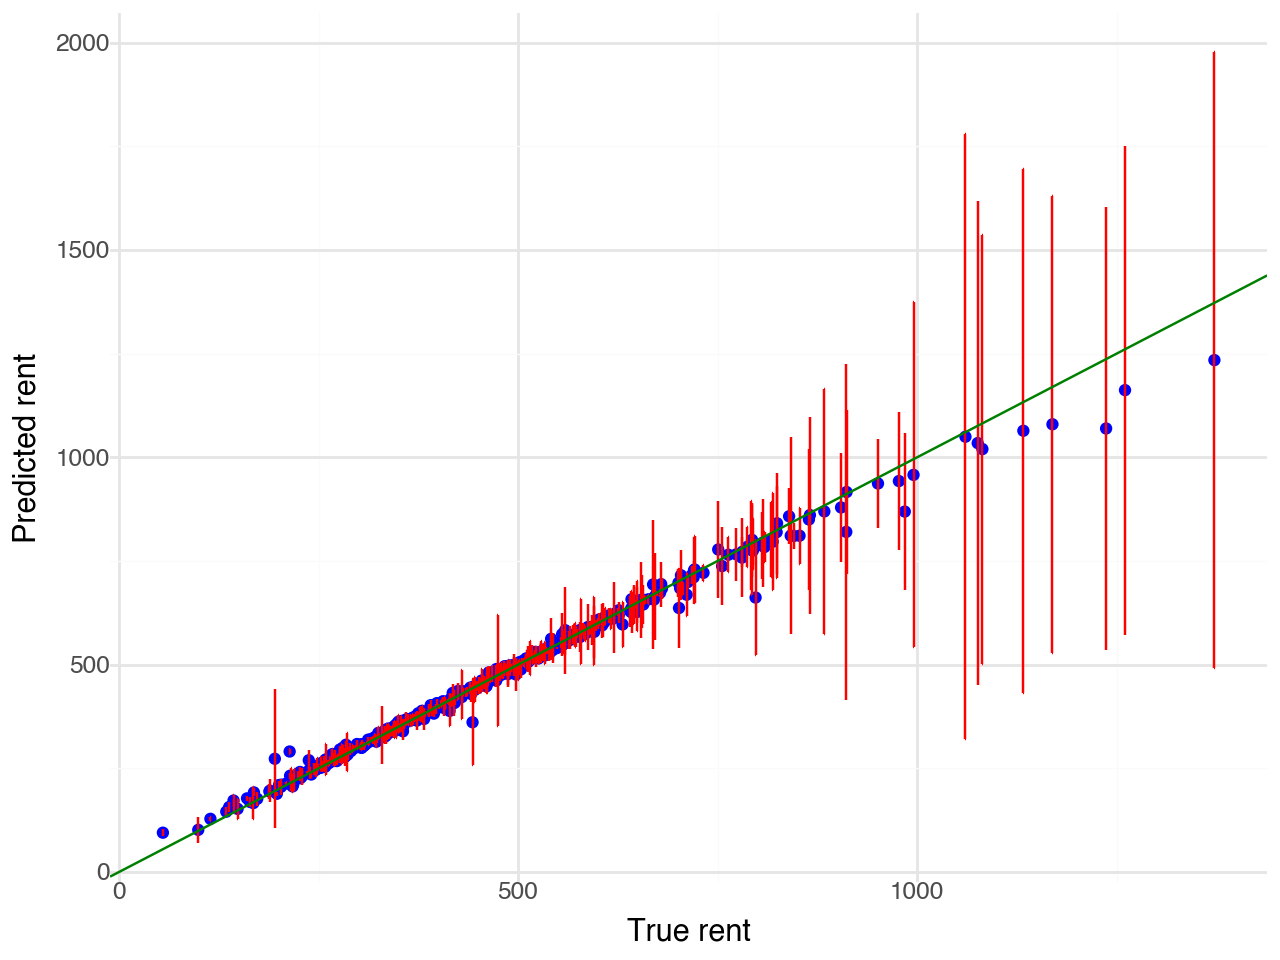

In [11]:
# Plot the predictions and the intervals and the true values using plotnine
df_plot = pl.DataFrame({
    "rent": y_new,
    "rent_pred": y_pred,
    "lower": lower,
    "upper": upper
}).to_pandas()
(    
ggplot(df_plot) +
    p9.geom_point(p9.aes(x="rent", y="rent_pred"), color="blue") +
    p9.geom_errorbar(p9.aes(x="rent", ymin="lower", ymax="upper"), color="red") +
    p9.geom_abline(intercept=0, slope=1, color="green") +
    p9.labs(x="True rent", y="Predicted rent") +
    p9.theme_minimal()
)

In [12]:
size = regression_mean_width_score(lower, upper)
cov = regression_coverage_score(y_new, lower, upper)
# 
print("Avg. interval size: {:.2f}".format(size))
print("Coverage: {:.2%}".format(cov))

Avg. interval size: 68.19
Coverage: 88.20%


/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/mapie/utils.py:621: UserWarning: WARNING: The predictions are ill-sorted.


## Now lets do the same with an Ensemble.

In [13]:
from sklearn.base import BaseEstimator
from sklearn.utils import check_X_y,check_array
from scipy.optimize import nnls
from scipy.optimize import minimize
from sklearn.utils.validation import check_is_fitted
# ConstrLS = "Constrained Least Squares" i.e. NNLS.
class ConstrLS(BaseEstimator):
    """
    Constrained least squares, weights sum to 1 and optionally >= 0
    """
    _estimator_type="regressor"
    
    def __init__(self, unit_interval: bool=True):
        self.unit_interval = unit_interval
        
    def fit(self, X, y):
        X,y = check_X_y(X,y, accept_sparse=True)
        xdim = X.shape[1]

        #Use nnls to get initial guess
        coef0, rnorm = nnls(X,y)

        #Define minimisation function
        def fn(coef, X, y):
            return np.linalg.norm(X.dot(coef) - y)
        
        #Constraints and bounds
        cons = {'type': 'eq', 'fun': lambda coef: np.sum(coef)-1}
        if self.unit_interval==True:
            bounds = [[0.0,1.0] for i in range(xdim)] 
        else:
            bounds = None

        #Do minimisation
        fit = minimize(fn,coef0,args=(X, y),method='SLSQP',
                       bounds=bounds,constraints=cons)
        self.coef_ = fit.x
        self.is_fitted_ = True
        self.cvalid=X
        return self
        
    def predict(self, X):
        X = check_array(X, accept_sparse=True)
        check_is_fitted(self, 'is_fitted_')
        return np.matmul(X,self.coef_)



In [14]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression as OLS

estimators = [
    ('rf', RandomForestRegressor(n_estimators=100)),
    ('dt', DecisionTreeRegressor(max_depth=5)),
    ('ols', OLS())
]

model_stack = StackingRegressor(
    estimators=estimators,
    final_estimator=ConstrLS()
)

model_stack.fit(X_train, y_train)
w = model_stack.final_estimator_.coef_
weights = pl.DataFrame(
    {"estimator": model_stack.named_estimators.keys(),
        'weight': model_stack.final_estimator_.coef_},
    )
print(weights)

shape: (3, 2)
┌───────────┬────────────┐
│ estimator ┆ weight     │
│ ---       ┆ ---        │
│ str       ┆ f64        │
╞═══════════╪════════════╡
│ rf        ┆ 0.873712   │
│ dt        ┆ 2.6586e-11 │
│ ols       ┆ 0.126288   │
└───────────┴────────────┘


In [69]:
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError

class StackingVariancePredictor(BaseEstimator):
    _estimator_type="regressor"
    
    def __init__(self, model: StackingRegressor):
        self._model = model
        
    def fit(self, X: np.ndarray | jnp.ndarray, y: np.ndarray | jnp.ndarray):
        try:
            check_is_fitted(self._model, 'estimators_')
            print("Model already fitted")
        except NotFittedError as e:
            self._model.fit(X, y)
    
    def predict(self, X: np.ndarray | jnp.ndarray, weighted_variance: bool =False) -> np.ndarray:
        # Get individual tree predictions
        all_predictions = np.array([base_model.predict(X) for base_model in self._model.estimators_])
        
        # if weighted_variance:
        #     all_predictions = all_predictions * w[:, np.newaxis]
        # 
        # variance_predictions = np.var(all_predictions, axis=0)
        return all_predictions
        # @njit
        # def compute_pairwise_diff(y):
        #     K = y.shape[1]
        #     results = np.zeros(y.shape[0])
        #     
        #     for i in range(y.shape[0]):
        #         abs_diff_matrix = np.abs(y[i, :, np.newaxis] - y[i, np.newaxis, :])
        #         sum_abs_diffs = np.sum(np.tril(abs_diff_matrix, -1))
        #         results[i] = (2 / (K * (K - 1))) * sum_abs_diffs
        #     
        #     return results
        # 
        # @njit
        # def compute_dist(y):
        #     if y.ndim == 1:
        #         K = len(y)
        #         abs_diff_matrix = np.abs(y[:, np.newaxis] - y[np.newaxis, :])
        #         sum_abs_diffs = np.sum(np.tril(abs_diff_matrix, -1))
        #         result = (2 / (K * (K - 1))) * sum_abs_diffs
        #         return np.array([result])
        #     else:
        #         return compute_pairwise_diff(y)
        # 
        # return compute_dist(all_predictions)

        
        

class AdaptiveConformalRegression:
    def __init__(self, prediction_fn, var_prediction_fn, alpha=0.1):
        self.prediction_fn = prediction_fn
        self.var_prediction_fn = var_prediction_fn
        self.alpha = alpha
        self.qhat = None

    def score_fn(self, y, y_hat, sigma_hat):
        return np.abs(y - y_hat) / sigma_hat

    def fit(self, X_calib, y_calib):
        # Compute y_hat_calib and sigma_hat_calib using prediction functions
        y_hat_calib = self.prediction_fn.predict(X_calib)
        sigma_hat_calib = self.var_prediction_fn.predict(X_calib)

        # Compute scores
        scores = np.array([self.score_fn(y, y_hat, sigma_hat) for y, y_hat, sigma_hat in zip(y_calib, y_hat_calib, sigma_hat_calib)])

        # Compute quantile
        self.qhat = np.quantile(scores, 1 - self.alpha)

    def predict_interval(self, X, **kwargs):
        y_hat = self.prediction_fn.predict(X)
        sigma_hat = self.var_prediction_fn.predict(X, **kwargs) # This is meant to be done using different data than the predict

        # Compute lower and upper bounds
        lower_bound = y_hat - self.qhat * sigma_hat
        upper_bound = y_hat + self.qhat * sigma_hat

        return np.array(lower_bound), np.array(upper_bound)

var_predictor = StackingVariancePredictor(model_stack)

adaptive_conformal = AdaptiveConformalRegression(model_stack, var_predictor)

adaptive_conformal.fit(X_calib, y_calib)

var_predictor.predict(adaptive_conformal.predict_interval(X_new))

# lower, upper = adaptive_conformal.predict_interval(X_new, weighted_variance=False)
# 
# df_plot = pl.DataFrame({
#     "rent": y_new,
#     "rent_pred": y_pred,
#     "lower": lower,
#     "upper": upper
# }).to_pandas()
# (    
# ggplot(df_plot) +
#     p9.geom_point(p9.aes(x="rent", y="rent_pred"), color="blue") +
#     p9.geom_errorbar(p9.aes(x="rent", ymin="lower", ymax="upper"), color="red") +
#     p9.geom_abline(intercept=0, slope=1, color="green") +
#     p9.labs(x="True rent", y="Predicted rent") +
#     p9.theme_minimal()
# )

/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names


ValueError: Found array with dim 3. RandomForestRegressor expected <= 2.

## Entropy Agreement Measure

In [169]:
import numpy as np
from scipy.stats import entropy

def entropy_agreement(predictions):
    # Discretize predictions into bins
    # hist, _ = np.histogram(predictions, bins=3, density=True)
    
    # Calculate entropy
    ent = entropy(predictions)
    
    # Normalize entropy to [0, 1] range
    max_ent = np.log(len(predictions))
    normalized_ent = ent #/ max_ent
    
    # Convert to an agreement measure (higher is more agreement)
    agreement = 1 - normalized_ent
    
    return agreement

# Example usage
predictions = np.array([model.predict(X) for model in model_stack.estimators_])
a_f = entropy_agreement(predictions)
a_f

array([ 0.28944535, -0.09531228, -0.08073649, ..., -0.09803372,
       -0.08109376, -0.09491284])

In [163]:
from scipy.stats import gaussian_kde
def kde_agreement(predictions):
    kde = gaussian_kde(predictions)
    
    # Evaluate KDE at prediction points
    density = kde.evaluate(predictions)
    
    # Use the average density as an agreement measure
    agreement = np.mean(density, axis=1)
    
    return agreement


kde_agreement(predictions)

AxisError: axis 1 is out of bounds for array of dimension 1

In [171]:
X[602,:]

rentsqm,area,year,location,bath,kitchen,cheating,district
f64,i64,date,i64,i64,i64,i64,i64
6.401338,69,1971-01-01,1,0,0,1,1012


In [ ]:
def QDF(predictions):
    # Quadratic Discrepancy Function
    n = predictions.shape[1]
    p = predictions.shape[0]
    
    def dist(i, j):
        return np.absolute(i - j)

In [34]:
def compute_sum(y):
    K = len(y)
    
    # Compute the pairwise absolute differences
    abs_diff_matrix = np.abs(y[:, np.newaxis] - y[np.newaxis, :])
    
    # Compute the sum of absolute differences for the given indices
    sum_abs_diffs = np.sum(np.tril(abs_diff_matrix, -1))
    
    return (2 / (K * (K - 1))) * sum_abs_diffs

# Example usage
y = np.array([1.0, 2.0, 3.0, 4.0])
result = compute_sum(y)
print(result)

1.6666666666666665


In [184]:
np.tril_indices(4, -1)

(array([1, 2, 2, 3, 3, 3]), array([0, 0, 1, 0, 1, 2]))

In [174]:
np.subtract.outer(y, y)

array([[ 0., -1., -2., -3.],
       [ 1.,  0., -1., -2.],
       [ 2.,  1.,  0., -1.],
       [ 3.,  2.,  1.,  0.]])

In [36]:
import numpy as np

def compute_dist(y):
    
    results = []
    
    # Check if y is a 1D array
    if y.ndim > 1:
        K = y.shape[1]
        for i in range(y.shape[0]):
            abs_diff_matrix = np.abs(y[i, :, np.newaxis] - y[i, np.newaxis, :])
            sum_abs_diffs = np.sum(np.tril(abs_diff_matrix, -1))
            results.append((2 / (K * (K - 1))) * sum_abs_diffs)
            
    else:
        K = len(y)
        abs_diff_matrix = np.abs(y[:, np.newaxis] - y[np.newaxis, :])
        sum_abs_diffs = np.sum(np.tril(abs_diff_matrix, -1))
        results.append((2 / (K * (K - 1))) * sum_abs_diffs)
    
    return np.array(results)

y = np.array([1.0, 2.0, 3.0])
result = compute_dist(y)
print(result)

[1.33333333]


In [32]:
np.array([[1.0, 2.0, 3.0], [1,2,3]]).ndim

2

In [39]:
import numpy as np
from numba import njit

@njit
def compute_pairwise_diff(y):
    K = y.shape[1]
    results = np.zeros(y.shape[0])
    
    for i in range(y.shape[0]):
        abs_diff_matrix = np.abs(y[i, :, np.newaxis] - y[i, np.newaxis, :])
        sum_abs_diffs = np.sum(np.tril(abs_diff_matrix, -1))
        results[i] = (2 / (K * (K - 1))) * sum_abs_diffs
    
    return results

@njit
def compute_dist(y):
    if y.ndim == 1:
        K = len(y)
        abs_diff_matrix = np.abs(y[:, np.newaxis] - y[np.newaxis, :])
        sum_abs_diffs = np.sum(np.tril(abs_diff_matrix, -1))
        result = (2 / (K * (K - 1))) * sum_abs_diffs
        return np.array([result])
    else:
        return compute_pairwise_diff(y)

y = np.array([[1.0, 2.0, 3.0], [2, 3, 4]])
result = compute_dist(y)
print(result)

[1.33333333 1.33333333]


In [47]:
var_predictor.predict(X_new)

array([201.18176402, 188.61084953, 200.90489021])